In [1]:
import requests
from requests.auth import HTTPBasicAuth
import astropy.table as at
import matplotlib
from matplotlib.transforms import Bbox
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.units as u
from astropy.visualization import PercentileInterval, AsinhStretch
from astroquery.mast import Catalogs
from astroquery.sdss import SDSS
from astroquery.simbad import Simbad
from astropy.table import Table

import pandas as pd

from PIL import Image
import os
import sys
import shutil
import glob
import json

import math

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

from alerce.core import Alerce
alerce = Alerce()

import antares_client

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

import sncosmo
import extinction

import warnings
warnings.filterwarnings("ignore")


In [2]:
smote_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
dataset_bank_tns_df = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_{smote_suffix}.csv.gz', compression='gzip', index_col=0)
dataset_bank_tns_df

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19abvhaqq,0.391695,0.368108,0.375000,0.000000,0.395856,0.783390,0.723513,0.435022,-0.830757,0.000424,...,0.493101,0.594500,0.698700,0.587200,43.259193,0.629409,Yes_TNS,None,-99.00000,ZTF
ZTF21aaswtkh,0.356501,0.355052,0.300000,0.000000,0.321765,0.713001,0.551514,0.300600,0.231450,0.000459,...,-0.026499,-0.157400,-0.083000,-0.157801,8.971037,0.034890,No_TNS,None,-99.00000,None
ZTF18abscghc,0.224128,0.290376,0.400000,0.000000,0.345730,0.448256,0.448256,0.169133,2.276334,0.003358,...,0.446798,0.523201,0.552601,0.673201,2.667939,0.236800,No_TNS,None,-99.00000,None
ZTF21abjpjcn,0.392974,0.806768,0.142857,0.142857,0.316430,0.785948,0.671357,0.204642,4.390367,-0.040870,...,-0.050900,0.008600,-0.069901,0.001501,14.958282,0.031570,Yes_TNS,None,-99.00000,ALeRCE
ZTF21aarhzdh,0.908470,0.317764,0.263158,0.000000,0.397708,1.816940,1.555440,0.847626,-0.448936,0.021725,...,0.554300,0.658100,0.554300,0.594801,22.116211,1.116821,Yes_TNS,SN Ia,0.06975,ALeRCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20acupxyy,0.630460,1.074418,0.400000,0.000000,0.457814,1.260920,1.047050,0.832848,-1.744178,0.027233,...,-0.096199,-0.062302,-0.075001,-0.101900,14.188714,2.588904,Yes_TNS,None,-99.00000,ZTF
ZTF21aarzxnb,0.121910,0.562210,0.142857,0.000000,0.376162,0.243820,0.218541,0.099431,1.578408,0.012642,...,0.172100,0.201801,-0.015202,-0.012701,0.801429,0.175727,Yes_TNS,None,-99.00000,ALeRCE
ZTF18acsxjhc,0.926579,1.119445,0.303797,0.037975,0.349061,1.801871,1.069640,0.539695,-0.012415,0.001636,...,0.748601,0.825200,0.762100,0.754800,42.918356,0.008771,Yes_TNS,None,-99.00000,iPTF


In [3]:
def calculate_band_mw_extinctions(bands):
    # modified from https://github.com/LSSTDESC/parsnip/blob/1a866fb8f75572e5a927588d1e55013ece312624/parsnip/instruments.py#L47
    band_mw_extinctions = []
    for band_name in bands:
        # Check if we should be correcting the extinction for this band.
        band = sncosmo.get_bandpass(band_name)
        band_mw_extinctions.append(extinction.fm07(np.array([band.wave_eff]), 3.1)[0])
    band_mw_extinctions = np.array(band_mw_extinctions)
    return band_mw_extinctions

In [4]:
calculate_band_mw_extinctions(['ztfg', 'ztfr'])

array([3.68860042, 2.47630754])

In [5]:
def get_extinction_corrected_mags_pb(band_extinction_curve, mwebv, magnitudes):
    from extinction import fm07, remove
    # Convert magnitudes to fluxes
    fluxes = 10**(-0.4 * (magnitudes-27.5))

    # Calculate the extinction correction
    extinction_correction = remove(band_extinction_curve, mwebv)

    # Apply the extinction correction to the fluxes
    corrected_fluxes = fluxes * 10**(0.4 * extinction_correction)

    # Convert corrected fluxes back to magnitudes
    corrected_magnitudes = 27.5 -2.5 * np.log10(corrected_fluxes)

    return corrected_magnitudes

In [6]:
def return_salt3_fit_params(z, time_arr, pb_arr, flux_arr, fluxerr_arr):
    model = sncosmo.Model(source='salt3')
    model.set(z=z)
    # Columns need to be: time, band, flux, fluxerr, zp, zpsys
    #https://sncosmo.readthedocs.io/en/latest/photdata.html
    lc_df = pd.DataFrame(zip(time_arr, pb_arr, flux_arr, fluxerr_arr), 
                         columns=["time", "band", "flux", "flux_err"])
    # Change passbands to those in registry (g == ps1::g)
    band_map = {'g': 'ztfg',
                'R': 'ztfr',
               }
    lc_df = lc_df.replace({"band": band_map})
    lc_df['zp'] = 27.5
    lc_df['zpsys'] = 'ab'

    lc_Table = Table.from_pandas(lc_df) # Astropy Table for SALT3
    #print(lc_Table) 

    try:
        res, fitted_model = sncosmo.fit_lc(lc_Table, model,
                                  ['t0', 'x0', 'x1', 'c'])
        param_dict = dict(zip(res['param_names'], res['parameters']))
        print(param_dict)
        model.set(z=param_dict['z'],t0=param_dict['t0'],
              x1=param_dict['x1'],c=param_dict['c'],x0=param_dict['x0'])

    except Exception as e:
        print(e)
        
    return lc_df, param_dict

In [7]:
def _calculate_band_mw_extinctions(bands=['ztfg', 'ztfr']):
        # modified from https://github.com/LSSTDESC/parsnip/blob/1a866fb8f75572e5a927588d1e55013ece312624/parsnip/instruments.py#L47
        band_mw_extinctions = []
        for band_name in bands:
            # Check if we should be correcting the extinction for this band.
            band = sncosmo.get_bandpass(band_name)
            band_mw_extinctions.append(extinction.fm07(np.array([band.wave_eff]), 3.1)[0])
            print(band_name, band.wave_eff)
        band_mw_extinctions = np.array(band_mw_extinctions)
        return band_mw_extinctions

In [8]:
band_mw_extinctions = _calculate_band_mw_extinctions()

ztfg 4813.948048935322
ztfr 6421.814890148709


In [9]:
def get_extinction_corrected_mags(mwebv, magnitudes, pbs):
    from extinction import fm07, remove
    
    def _calculate_band_mw_extinctions(bands=['ztfg', 'ztfr']):
        # modified from https://github.com/LSSTDESC/parsnip/blob/1a866fb8f75572e5a927588d1e55013ece312624/parsnip/instruments.py#L47
        band_mw_extinctions = []
        for band_name in bands:
            # Check if we should be correcting the extinction for this band.
            band = sncosmo.get_bandpass(band_name)
            band_mw_extinctions.append(extinction.fm07(np.array([band.wave_eff]), 3.1)[0])
            #print(band_name, band.wave_eff)
        band_mw_extinctions = np.array(band_mw_extinctions)
        return band_mw_extinctions
    
    band_mw_extinctions = _calculate_band_mw_extinctions()
    
    corrected_fluxes, corrected_magnitudes, A_lambdas = [], [], []
    for mag, pb in zip(magnitudes, pbs):
        if pb == 'g': 
            band_mw_ext = band_mw_extinctions[0]
            A_lambda = extinction.fm07(np.array([4813.948048935322]), 3.1) * mwebv
        elif pb == 'R': 
            band_mw_ext = band_mw_extinctions[1]
            A_lambda = extinction.fm07(np.array([6421.814890148709]), 3.1) * mwebv
            
        # Convert magnitudes to fluxes
        flux = 10**(-0.4 * (mag-27.5))

        # Calculate the extinction correction
        extinction_correction = remove(band_mw_ext, mwebv)

        # Apply the extinction correction to the fluxes
        corrected_flux = flux * 10**(0.4 * extinction_correction)
        corrected_fluxes.append(corrected_flux)

        # Convert corrected fluxes back to magnitudes
        corrected_mag = 27.5 -2.5 * np.log10(corrected_flux)
        corrected_magnitudes.append(corrected_mag)
        
        A_lambdas.append(A_lambda[0])
    
    return np.array(corrected_fluxes), np.array(corrected_magnitudes), np.array(A_lambdas)

{'z': 0.04, 't0': 59299.00671224242, 'x0': 0.002425759581341161, 'x1': -0.32097431170378576, 'c': 0.04874598290412147}
{'z': 0.04, 't0': 59299.11969946395, 'x0': 0.007210829095111987, 'x1': -0.24598733079135654, 'c': -0.5357906246607347}


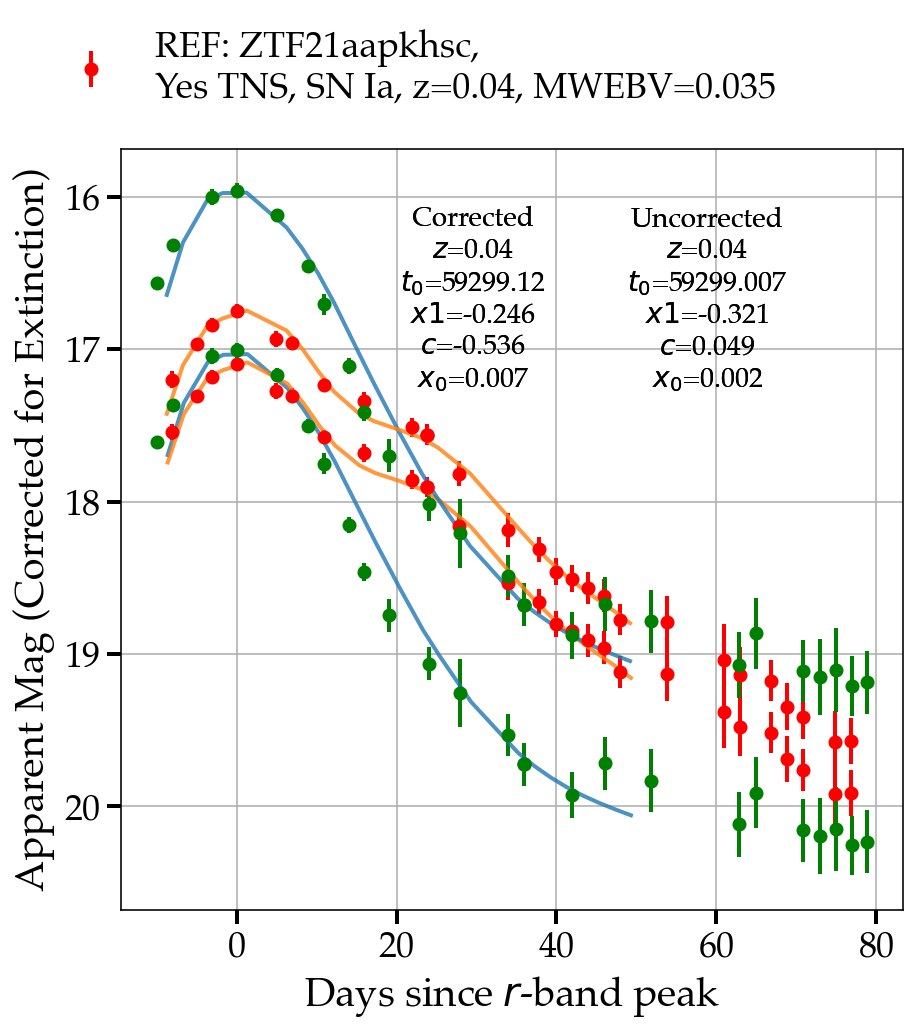

CPU times: user 2.09 s, sys: 163 ms, total: 2.25 s
Wall time: 1.95 s


In [10]:
%%time

ztf_id_ref = "ZTF21aapkhsc"
mwebv = 0.035
z= 0.04

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

#ztf_id_ref = ztf_id_ref #idx_arr[result_id[0]]
ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

# ra_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].raMean
# dec_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].decMean  

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

# Uncorrected
ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')

# apply SALT3 fit
time_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mjd.values
pb_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_passband.values
mag_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mag.values
flux_arr_ref = 10**(-0.4 * (mag_arr_ref-27.5))
flux_corrected_arr_ref, mag_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=mag_arr_ref, pbs=pb_arr_ref)
magerr_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_magerr.values
fluxerr_corrected_arr_ref_notreal, magerr_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=magerr_arr_ref, pbs=pb_arr_ref)
fluxerr_arr_ref = (magerr_arr_ref*flux_arr_ref)/1.0857
fluxerr_corrected_arr_ref = (magerr_arr_ref*flux_corrected_arr_ref)/1.0857 #flux_arr_ref * 10**(0.4 * A_lambda_arr)
lc_df, param_dict = return_salt3_fit_params(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_arr_ref, fluxerr_arr=fluxerr_arr_ref)
lc_df_corrected, param_dict_corrected = return_salt3_fit_params(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_corrected_arr_ref, fluxerr_arr=fluxerr_corrected_arr_ref)


for i,f in enumerate(np.unique(lc_df['band'])):
    z= round(param_dict['z'], 3)
    t0= round(param_dict['t0'], 3)
    x1= round(param_dict['x1'], 3)
    c= round(param_dict['c'], 3)
    x0= round(param_dict['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict['t0'], x1=param_dict['x1'],c=param_dict['c'],x0=param_dict['x0'])
    salt3flux = model.bandflux(f, lc_df['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)

    ax.text(0.75, 0.80, "Uncorrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$t_0$={t0}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
            horizontalalignment='center', 
             verticalalignment='center', 
             transform=ax.transAxes,
             fontsize=14)

# Corrected
corrected_mags_r = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfr'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_r.ant_mag.values)
corrected_mags_g = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfg'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_g.ant_mag.values)
ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=corrected_mags_r, yerr=df_ref_r.ant_magerr, fmt='o', c='r',
           label=f'REF: {ztf_id_ref}, \n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}, MWEBV={mwebv}')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=corrected_mags_g, yerr=df_ref_g.ant_magerr, fmt='o', c='g')

for i,f in enumerate(np.unique(lc_df['band'])):
    z= round(param_dict_corrected['z'], 3)
    t0= round(param_dict_corrected['t0'], 3)
    x1= round(param_dict_corrected['x1'], 3)
    c= round(param_dict_corrected['c'], 3)
    x0= round(param_dict_corrected['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict_corrected['t0'], x1=param_dict_corrected['x1'],c=param_dict_corrected['c'],x0=param_dict_corrected['x0'])
    salt3flux = model.bandflux(f, lc_df['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)

    ax.text(0.45, 0.80, "Corrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$t_0$={t0}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
            horizontalalignment='center', 
             verticalalignment='center', 
             transform=ax.transAxes,
             fontsize=14)

plt.ylabel('Apparent Mag (Corrected for Extinction)')
plt.xlabel('Days since $r$-band peak')
plt.legend(frameon=False,
           bbox_to_anchor=(0.88,1.2),
           ncol=1,
           prop={'size': 18})

plt.gca().invert_yaxis()
plt.grid(True)

folder_path = f"../figures/salt3/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/salt3/{ztf_id_ref}_corrected_vs_uncorrected.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# SALT 3 for corrected

{'z': 0.04, 't0': 59299.11969946395, 'x0': 0.007210829095111987, 'x1': -0.24598733079135654, 'c': -0.5357906246607347}
0 ('ZTF20acifwef', 0.0364, 0.022, 'SN Ia')
{'z': 0.0364, 't0': 59146.69738751925, 'x0': 0.005735445412202709, 'x1': -0.3663407593059105, 'c': -0.3719453825856365}
1 ('ZTF20actoakx', 0.03, 0.023, 'SN Ia')
{'z': 0.03, 't0': 59192.88343999475, 'x0': 0.0058460626824461065, 'x1': 1.5867379192546323, 'c': -0.32857729947811454}
2 ('ZTF21aamfcji', 0.046105, 0.012, 'SN Ia')
{'z': 0.046105, 't0': 59281.04365402516, 'x0': 0.002201369055854071, 'x1': 0.2716393817054958, 'c': -0.07711780698566567}
3 ('ZTF21abcrhpk', 0.0744, 0.05, 'SN Ia')
{'z': 0.0744, 't0': 59374.966557874206, 'x0': 0.00355527636264538, 'x1': 1.5067232782947684, 'c': -0.7513052572477984}
4 ('ZTF21aagycrc', 0.068, 0.009, 'SN Ia')
{'z': 0.068, 't0': 59250.19052152996, 'x0': 0.0016612756089088587, 'x1': 0.631828575836791, 'c': -0.26993515025674336}
5 ('ZTF20abylbuf', 0.0468, 0.088, 'SN Ia')
result is NaN for [ 0.0468

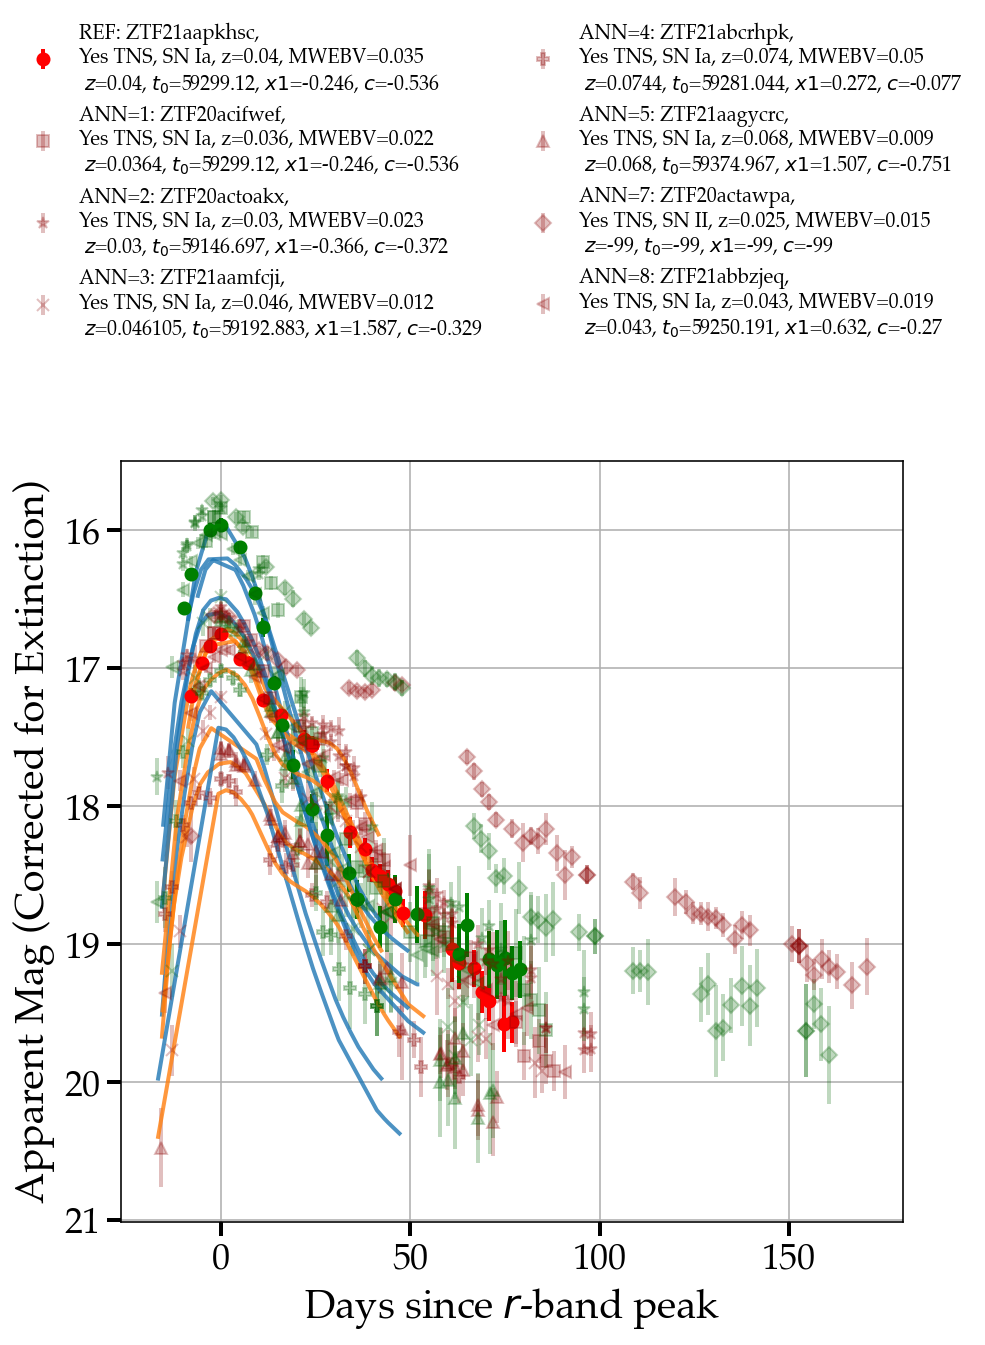

CPU times: user 6.66 s, sys: 617 ms, total: 7.28 s
Wall time: 6.9 s


In [12]:
%%time

ztf_id_ref = "ZTF21aapkhsc"
mwebv = 0.035
z= 0.04

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag


# apply SALT3 fit
time_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mjd.values
pb_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_passband.values
mag_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mag.values
flux_arr_ref = 10**(-0.4 * (mag_arr_ref-27.5))
flux_corrected_arr_ref, mag_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=mag_arr_ref, pbs=pb_arr_ref)
magerr_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_magerr.values
fluxerr_corrected_arr_ref_notreal, magerr_corrected_arr_ref, A_lambda_arr = get_extinction_corrected_mags(mwebv=mwebv, magnitudes=magerr_arr_ref, pbs=pb_arr_ref)
fluxerr_arr_ref = (magerr_arr_ref*flux_arr_ref)/1.0857
fluxerr_corrected_arr_ref = (magerr_arr_ref*flux_corrected_arr_ref)/1.0857 #flux_arr_ref * 10**(0.4 * A_lambda_arr)
lc_df_corrected_ref, param_dict_corrected_ref = return_salt3_fit_params(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_corrected_arr_ref, fluxerr_arr=fluxerr_corrected_arr_ref)

# Corrected
corrected_mags_r = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfr'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_r.ant_mag.values)
corrected_mags_g = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfg'])[0], 
                                                 mwebv=mwebv, magnitudes=df_ref_g.ant_mag.values)
ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=corrected_mags_r, yerr=df_ref_r.ant_magerr, fmt='o', c='r',
           label=f"REF: {ztf_id_ref}, \n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}, MWEBV={mwebv}\n $z$={z}, $t_0$={t0}, $x1$={x1}, $c$={c}")
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=corrected_mags_g, yerr=df_ref_g.ant_magerr, fmt='o', c='g')

for i,f in enumerate(np.unique(lc_df_corrected_ref['band'])):
    z= round(param_dict_corrected_ref['z'], 3)
    t0= round(param_dict_corrected_ref['t0'], 3)
    x1= round(param_dict_corrected_ref['x1'], 3)
    c= round(param_dict_corrected_ref['c'], 3)
    x0= round(param_dict_corrected_ref['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict_corrected_ref['t0'], x1=param_dict_corrected_ref['x1'],c=param_dict_corrected_ref['c'],x0=param_dict_corrected_ref['x0'])
    salt3flux = model.bandflux(f, lc_df_corrected_ref['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df_corrected_ref['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)

    #ax.text(0.45, 0.80, "Corrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$t_0$={t0}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
    #        horizontalalignment='center', 
    #         verticalalignment='center', 
    #         transform=ax.transAxes,
    #         fontsize=14)
    



    
    
markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = ["ZTF20acifwef", "ZTF20actoakx", "ZTF21aamfcji", "ZTF21abcrhpk", "ZTF21aagycrc",
            "ZTF20abylbuf", "ZTF20actawpa", "ZTF21abbzjeq"]
z_l = [0.0364, 0.03, 0.046105, 0.0744, 0.068, 0.0468, 0.025, 0.043]
mwebv_l = [0.022, 0.023, 0.012, 0.05, 0.009, 0.088, 0.015, 0.019]
spec_cls_l = ["SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN II", "SN Ia"]


for num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn) in enumerate(zip(ztf_id_l, z_l, mwebv_l, spec_cls_l)):
    print(num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn))
    ztf_id_ann = ztf_id_knn

    try:
        l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
        df_knn = l_info.timeseries.to_pandas()
    except: continue  
    
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z


    df_knn_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_knn_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]
    
    mjd_idx_at_min_mag_r_knn = df_knn_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_knn = df_knn_g[['ant_mag']].reset_index().idxmin().ant_mag
    
    # apply SALT3 fit
    time_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mjd.values
    pb_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_passband.values
    mag_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mag.values
    flux_arr_knn = 10**(-0.4 * (mag_arr_knn-27.5))
    flux_corrected_arr_knn, mag_corrected_arr_knn, A_lambda_arr_knn = get_extinction_corrected_mags(mwebv=mwebv_knn, magnitudes=mag_arr_knn, pbs=pb_arr_knn)
    magerr_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_magerr.values
    fluxerr_corrected_arr_knn_notreal, magerr_corrected_arr_knn, A_lambda_arr_knn = get_extinction_corrected_mags(mwebv=mwebv_knn, magnitudes=magerr_arr_knn, pbs=pb_arr_knn)
    fluxerr_arr_knn = (magerr_arr_knn*flux_arr_knn)/1.0857
    fluxerr_corrected_arr_knn = (magerr_arr_knn*flux_corrected_arr_knn)/1.0857 #flux_arr_ref * 10**(0.4 * A_lambda_arr)
    # Corrected
    corrected_mags_r_knn = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfr'])[0], 
                                                     mwebv=mwebv, magnitudes=df_knn_r.ant_mag.values)
    corrected_mags_g_knn = get_extinction_corrected_mags_pb(band_extinction_curve=calculate_band_mw_extinctions(['ztfg'])[0], 
                                                     mwebv=mwebv, magnitudes=df_knn_g.ant_mag.values)
    
    if spec_cls_knn == "SN Ia":
        try:
            lc_df_corrected_knn, param_dict_corrected_knn = return_salt3_fit_params(z=z_knn, time_arr=time_arr_knn, pb_arr=pb_arr_knn, flux_arr=flux_corrected_arr_knn, fluxerr_arr=fluxerr_corrected_arr_knn)
        except: 
            print("Bad SALT FIT, continue..")
            continue
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=corrected_mags_r_knn, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$={z_knn}, $t_0$={t0}, $x1$={x1}, $c$={c}")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=corrected_mags_g_knn, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
    
    else:
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=corrected_mags_r_knn, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$=-99, $t_0$=-99, $x1$=-99, $c$=-99")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=corrected_mags_g_knn, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
    
    if spec_cls_knn == "SN Ia":
        for i,f in enumerate(np.unique(lc_df_corrected_knn['band'])):
            z= round(param_dict_corrected_knn['z'], 3)
            t0= round(param_dict_corrected_knn['t0'], 3)
            x1= round(param_dict_corrected_knn['x1'], 3)
            c= round(param_dict_corrected_knn['c'], 3)
            x0= round(param_dict_corrected_knn['x0'], 3)
            # careful about zpsys!
            model = sncosmo.Model(source='salt3')
            model.set(z=z_knn,t0=param_dict_corrected_knn['t0'], x1=param_dict_corrected_knn['x1'],c=param_dict_corrected_knn['c'],x0=param_dict_corrected_knn['x0'])

            salt3flux = model.bandflux(f, lc_df_corrected_knn['time'], zp=27.5, zpsys='AB')
            salt3mag = 27.5 -2.5 * np.log10(salt3flux)
            ax.plot(lc_df_corrected_knn['time']-t0,salt3mag,color='C%i'%i, alpha=0.8, linewidth=2)


plt.ylabel('Apparent Mag (Corrected for Extinction)')
plt.xlabel('Days since $r$-band peak')
plt.legend(frameon=False,
           bbox_to_anchor=(1.1,1.6),
           ncol=2,
           prop={'size': 10})

plt.gca().invert_yaxis()
plt.grid(True)

folder_path = f"../figures/salt3/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/salt3/{ztf_id_ref}_corrected_ANN0-8.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
%%time

ztf_id_ref = "ZTF21aapkhsc"
mwebv = 0.035
z= 0.04

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag


# apply SALT3 fit
time_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mjd.values
pb_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_passband.values
mag_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_mag.values
flux_arr_ref = 10**(-0.4 * (mag_arr_ref-27.5))
magerr_arr_ref = df_ref[(~df_ref.ant_mag.isna())].ant_magerr.values
fluxerr_arr_ref = (magerr_arr_ref*flux_arr_ref)/1.0857
lc_df_ref, param_dict_ref = return_salt3_fit_params(z=z, time_arr=time_arr_ref, pb_arr=pb_arr_ref, flux_arr=flux_arr_ref, fluxerr_arr=fluxerr_arr_ref)

# UnCorrected
ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r',
           label=f"REF: {ztf_id_ref}, \n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}, MWEBV={mwebv}\n $z$={z}, $t_0$={t0}, $x1$={x1}, $c$={c}")
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')

ref_colors = ['g', 'r']
for i,f in enumerate(np.unique(lc_df_ref['band'])):
    if f == "ztfr": min_band_mag = df_ref_r.ant_mag.min()
    elif f == "ztfg": min_band_mag = df_ref_g.ant_mag.min()
    
    z= round(param_dict_ref['z'], 3)
    t0= round(param_dict_ref['t0'], 3)
    x1= round(param_dict_ref['x1'], 3)
    c= round(param_dict_ref['c'], 3)
    x0= round(param_dict_ref['x0'], 3)

    # careful about zpsys!
    model = sncosmo.Model(source='salt3')
    model.set(z=z,t0=param_dict_ref['t0'], x1=param_dict_ref['x1'],c=param_dict_ref['c'],x0=param_dict_ref['x0'])
    salt3flux = model.bandflux(f, lc_df_corrected_ref['time'], zp=27.5, zpsys='AB')
    salt3mag = 27.5 -2.5 * np.log10(salt3flux)
    ax.plot(lc_df_ref['time']-t0,min_band_mag-salt3mag,color=ref_colors[i], alpha=0.8, linewidth=3)

    #ax.text(0.45, 0.80, "Corrected"+'\n'+ fr"$z$={z}"+'\n'+ fr"$t_0$={t0}"+'\n'+ fr"$x1$={x1}"+'\n'+ fr"$c$={c}"+'\n'+ fr"$x_0$={x0}",#+'\n'+ fr"$m_{pkflt}$={pkmag}", 
    #        horizontalalignment='center', 
    #         verticalalignment='center', 
    #         transform=ax.transAxes,
    #         fontsize=14)
    



    
    
markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = ["ZTF20acifwef", "ZTF20actoakx", "ZTF21aamfcji", "ZTF21abcrhpk", "ZTF21aagycrc",
            "ZTF20abylbuf", "ZTF20actawpa", "ZTF21abbzjeq"]
z_l = [0.0364, 0.03, 0.046105, 0.0744, 0.068, 0.0468, 0.025, 0.043]
mwebv_l = [0.022, 0.023, 0.012, 0.05, 0.009, 0.088, 0.015, 0.019]
spec_cls_l = ["SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN Ia", "SN II", "SN Ia"]


knn_colors = ['darkgreen', 'darkred']
for num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn) in enumerate(zip(ztf_id_l, z_l, mwebv_l, spec_cls_l)):
    print(num, (ztf_id_knn, z_knn, mwebv_knn, spec_cls_knn))
    ztf_id_ann = ztf_id_knn

    try:
        l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
        df_knn = l_info.timeseries.to_pandas()
    except: continue  
    
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z


    df_knn_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_knn_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]
    
    mjd_idx_at_min_mag_r_knn = df_knn_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_knn = df_knn_g[['ant_mag']].reset_index().idxmin().ant_mag
    
    # apply SALT3 fit
    time_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mjd.values
    pb_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_passband.values
    mag_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_mag.values
    flux_arr_knn = 10**(-0.4 * (mag_arr_knn-27.5))
    magerr_arr_knn = df_knn[(~df_knn.ant_mag.isna())].ant_magerr.values
    fluxerr_arr_knn = (magerr_arr_knn*flux_arr_knn)/1.0857
    
    if spec_cls_knn == "SN Ia":
        try:
            lc_df_knn, param_dict_knn = return_salt3_fit_params(z=z_knn, time_arr=time_arr_knn, pb_arr=pb_arr_knn, flux_arr=flux_arr_knn, fluxerr_arr=fluxerr_arr_knn)
        except: 
            print("Bad SALT FIT, continue..")
            continue
        # Corrected
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$={z_knn}, $t_0$={t0}, $x1$={x1}, $c$={c}")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
        
    else: 
        ax.errorbar(x=df_knn_r.ant_mjd-df_knn_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_knn], y=df_knn_r.ant_mag.min()-df_knn_r.ant_mag, yerr=df_knn_r.ant_magerr, fmt=markers[num], c='darkred', alpha=0.25, 
                   label=f"ANN={num+1}: {ztf_id_knn}, \n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}, MWEBV={mwebv_knn}\n $z$=-99, $t_0$=-99, $x1$=-99, $c$=-99")
        ax.errorbar(x=df_knn_g.ant_mjd-df_knn_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_knn], y=df_knn_g.ant_mag.min()-df_knn_g.ant_mag, yerr=df_knn_g.ant_magerr, fmt=markers[num], c='darkgreen', alpha=0.25)
    
    if spec_cls_knn == "SN Ia":
        for i,f in enumerate(np.unique(lc_df_knn['band'])):
            if f == "ztfr": min_band_mag = df_knn_r.ant_mag.min()
            elif f == "ztfg": min_band_mag = df_knn_g.ant_mag.min()

            z= round(param_dict_knn['z'], 3)
            t0= round(param_dict_knn['t0'], 3)
            x1= round(param_dict_knn['x1'], 3)
            c= round(param_dict_knn['c'], 3)
            x0= round(param_dict_knn['x0'], 3)
            # careful about zpsys!
            model = sncosmo.Model(source='salt3')
            model.set(z=z_knn,t0=param_dict_knn['t0'], x1=param_dict_knn['x1'],c=param_dict_knn['c'],x0=param_dict_knn['x0'])

            salt3flux = model.bandflux(f, lc_df_knn['time'], zp=27.5, zpsys='AB')
            salt3mag = 27.5 -2.5 * np.log10(salt3flux)
            ax.plot(lc_df_knn['time']-t0,min_band_mag-salt3mag,color=knn_colors[i], alpha=0.6, linewidth=2)

    if df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref] <= 10:
            plt.xlim((df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref])-20, 
                     df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    else: 
        plt.xlim(2*(df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref]), 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
        
        
plt.ylabel('Apparent Mag. + Constant')
#plt.xlabel('Days of event') # make iloc[0]
plt.xlabel('Days since peak ($r$, $g$ indep.)') # (need r, g to be same)
plt.legend(frameon=False,
           bbox_to_anchor=(1.1,1.60),
           ncol=2,
           prop={'size': 10})

#plt.gca().invert_yaxis()
plt.grid(True)

folder_path = f"../figures/salt3/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/salt3/{ztf_id_ref}_uncorrected_ANN0-8.jpg', dpi=300, bbox_inches='tight')
plt.show()

{'z': 0.04, 't0': 59299.00671224242, 'x0': 0.002425759581341161, 'x1': -0.32097431170378576, 'c': 0.04874598290412147}
0 ('ZTF20acifwef', 0.0364, 0.022, 'SN Ia')
{'z': 0.0364, 't0': 59146.167652714736, 'x0': 0.002877707414315712, 'x1': -0.2588716854886155, 'c': -0.00698210875453269}
1 ('ZTF20actoakx', 0.03, 0.023, 'SN Ia')
{'z': 0.03, 't0': 59192.84255570767, 'x0': 0.002818888748854133, 'x1': 1.492957804686442, 'c': 0.058813147516322196}
2 ('ZTF21aamfcji', 0.046105, 0.012, 'SN Ia')
{'z': 0.046105, 't0': 59281.02742503893, 'x0': 0.001515484783592008, 'x1': 0.23888557711520303, 'c': 0.12436002830947657}
3 ('ZTF21abcrhpk', 0.0744, 0.05, 'SN Ia')
{'z': 0.0744, 't0': 59374.858805376156, 'x0': 0.0008746865666487909, 'x1': 1.3170570101690786, 'c': 0.03451487889640139}
4 ('ZTF21aagycrc', 0.068, 0.009, 'SN Ia')
{'z': 0.068, 't0': 59250.18892623938, 'x0': 0.0012819669493059226, 'x1': 0.5931944006797305, 'c': -0.1262839313740833}
5 ('ZTF20abylbuf', 0.0468, 0.088, 'SN Ia')
